In [1]:
# multi-headed cnn model
import os
from scipy import stats
from numpy import mean
from numpy import std
from numpy import dstack
import numpy as np
import pandas as pd
from pandas import read_csv
from matplotlib import pyplot
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split

from keras import backend as K
import tensorflow as tf

Using TensorFlow backend.


In [2]:
def cm_analysis(y_true, y_pred, labels, classes, ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
                
    cm = pd.DataFrame(cm, index=classes, columns=classes)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)
    #plt.savefig(filename)
    plt.show()

# cm_analysis(y_test, y_pred, model.classes_, ymap=None, figsize=(10,10))

In [3]:
def train_model2(trainX, trainy):
    verbose, epochs, batch_size = 0, 2, 32
    callbacks = [EarlyStopping(monitor='val_loss', patience=18)]
    
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    # Head 1 
    inputs1 = Input(shape=(n_timesteps, n_features))
    conv1_1 = Conv1D(filters=128, kernel_size=3, activation='relu')(inputs1)
    conv1_2 = Conv1D(filters=128, kernel_size=3, activation='relu')(conv1_1)
    drop1 = Dropout(0.5)(conv1_2)
    pool1 = MaxPooling1D(pool_size=2)(drop1)
    flat1 = Flatten()(pool1)
    
    # Interpretation
    dense1 = Dense(512, activation='relu')(flat1)
    dense2 = Dense(n_outputs*4, activation='relu')(dense1)
    outputs = Dense(n_outputs, activation='softmax')(dense2)
    model = Model(inputs = inputs1, outputs=outputs)
    plot_model(model, show_shapes=True, to_file='multichannel.png')
    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    history = model.fit(trainX, trainy, validation_split=0.33,callbacks=callbacks, 
              epochs=epochs, batch_size=batch_size, verbose=verbose)    

    print(history.history.keys())
    
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    return model

def train_model(trainX, trainy):
    verbose, epochs, batch_size = 0, 2, 32
    callbacks = [EarlyStopping(monitor='val_loss', patience=18)]
    
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    # Head 1 
    inputs1 = Input(shape=(n_timesteps, n_features))
    conv1_1 = Conv1D(filters=128, kernel_size=3, activation='relu')(inputs1)
    conv1_2 = Conv1D(filters=128, kernel_size=3, activation='relu')(conv1_1)
    drop1 = Dropout(0.5)(conv1_2)
    pool1 = MaxPooling1D(pool_size=2)(drop1)
    flat1 = Flatten()(pool1)
    
    # Head 2
    inputs2 = Input(shape=(n_timesteps, n_features))
    conv2_1 = Conv1D(filters=128, kernel_size=5, activation='relu')(inputs2)
    conv2_2 = Conv1D(filters=128, kernel_size=5, activation='relu')(conv2_1)
    
#     conv2 = Conv1D(filters=128, kernel_size=5, activation='relu')(inputs2)
    drop2 = Dropout(0.5)(conv2_2)
    pool2 = MaxPooling1D(pool_size=2)(drop2)
    flat2 = Flatten()(pool2)
    
    # Head 3
    inputs3 = Input(shape=(n_timesteps, n_features))
    conv3_1 = Conv1D(filters=128, kernel_size=11, activation='relu')(inputs3)
    conv3_2 = Conv1D(filters=128, kernel_size=11, activation='relu')(conv3_1)
    
#     conv3 = Conv1D(filters=128, kernel_size=11, activation='relu')(inputs3)
    drop3 = Dropout(0.5)(conv3_2)
    pool3 = MaxPooling1D(pool_size=2)(drop3)
    flat3 = Flatten()(pool3)  
    # merge
    merged = concatenate([flat1, flat2, flat3])
    # Interpretation
    dense1 = Dense(512, activation='relu')(merged)
    dense2 = Dense(n_outputs*4, activation='relu')(dense1)
    outputs = Dense(n_outputs, activation='softmax')(dense2)
    model = Model(inputs = [inputs1, inputs2, inputs3], outputs=outputs)
    plot_model(model, show_shapes=True, to_file='multichannel.png')
    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    history = model.fit([trainX,trainX,trainX], trainy, validation_split=0.33,callbacks=callbacks, 
              epochs=epochs, batch_size=batch_size, verbose=verbose)    

    print(history.history.keys())
    
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    return model

def test_model(testX, testy, model, classes, repeats=10):
    pred = model.predict([testX, testX, testX])
    predy = pred.argmax(axis=-1)
    testy = testy.argmax(axis=-1)
    labels = [0,1,2,3,4,5,6,7,8,9,10,11]
    cm_analysis(testy, predy, labels, classes, ymap=None, figsize=(10,10))
    matrix = confusion_matrix(testy, predy)
    print(matrix) 
    
def test_model2(testX, testy, model, classes, repeats=10):
    pred = model.predict(testX)
    predy = pred.argmax(axis=-1)
    testy = testy.argmax(axis=-1)
    labels = [0,1,2,3,4,5,6,7,8,9,10,11]
    cm_analysis(testy, predy, labels, classes, ymap=None, figsize=(10,10))
    matrix = confusion_matrix(testy, predy)
    print(matrix) 
    
def get_model_accuracy(testX, testy, model, batch_size=32, repeats=10):
    scores = []
    for r in range(repeats):
        _, accuracy = model.evaluate([testX,testX,testX], testy, batch_size=batch_size, verbose=0)
        score = accuracy * 100.0
        scores.append(score)
        
    summarize_results(scores)

def get_model_accuracy2(testX, testy, model, batch_size=32, repeats=10):
    scores = []
    for r in range(repeats):
        _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
        score = accuracy * 100.0
        scores.append(score)
        
    summarize_results(scores)

# summarize scores
def summarize_results(scores):
    print(scores)
    m, s = mean(scores), std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = tf.graph_util.convert_variables_to_constants(
            session, input_graph_def, output_names, freeze_var_names)
        return frozen_graph

In [4]:
# Segmenting the Signal
WINDOW_SIZE = 90

def read_data(file_path):
    data = pd.read_csv(file_path,header = None, names = None)
    return data

def windows(data, size):
    start = 0
    count = data.shape[0]
    while start < count:
        yield start, start + size
        start += int(size / 2)
        
def string_to_arr_parser(string, type='integer'):
    """ Takes in a string and returns an float array
    """
    arr = np.array(string.split(" "))
    if type == 'integer':
        arr = arr.astype(np.int)
    else:
        arr = arr.astype(np.float64)
    return arr
    
def segment_signal(data, activity, window_size = WINDOW_SIZE):
    segments = np.empty((0,window_size,3))
    labels = np.empty((0))
    for (start, end) in windows(data, window_size):
        d = data[start:end]
        x = d[:,0]
        y = d[:,1]
        z = d[:,2]

        if(len(x) == window_size and len(y) == window_size and len(z) == window_size):
            d = d.reshape((1,90,3))
            segments = np.vstack((segments,d))
            labels = np.append(labels, activity)

    return segments, labels

def segment_signal2(acc_data, gyro_data, activity, window_size = WINDOW_SIZE):
    segments = np.empty((0,window_size,6))
    labels = []
    for (start, end) in windows(acc_data, window_size):
        ad = acc_data[start:end]
        gd = gyro_data[start:end]
        ax = ad[:,0]
        ay = ad[:,1]
        az = ad[:,2]
        gx = gd[:,0]
        gy = gd[:,1]
        gz = gd[:,2]

        if(len(ax) == window_size and len(ay) == window_size and len(az) == window_size 
           and len(gx) == window_size and len(gy) == window_size and len(gz) == window_size):
            d = np.hstack((ad,gd))
            d = d.reshape((1,window_size,6))
            segments = np.vstack((segments,d))
            labels.append(activity)
            
    labels = np.array(labels)
    return segments, labels

def get_activity_window(exp_num, user_id, act_dict):
    ref_key = exp_num * 100 + user_id
    return act_dict[ref_key]

def get_activity_dict(arr):
    act_dict = {}
    for value in arr:
        exp_num, user_id, activity, start, end = value
        ref_key = exp_num * 100 + user_id
        if (ref_key in act_dict.keys()):
            act_dict[ref_key].append([activity, start, end])
        else:
            act_dict[ref_key] = [[activity, start, end]]
    return act_dict

In [5]:
# Raw data path
raw_data_path = "/home/luishengjie/workspace/har/data/hapt/RawData"
raw_data_files = os.listdir(raw_data_path)
print(raw_data_files[0])

acc_exp20_user10.txt


In [6]:
# Set max col width
pd.set_option('display.max_colwidth', -1)

# Read raw labels data
labels = read_data(os.path.join(raw_data_path,'labels.txt'))
updated_labels = []

for l in labels.values:
    updated_labels.append(string_to_arr_parser(l[0], type='integer'))
    
updated_labels = np.array(updated_labels)
activity_dict = get_activity_dict(updated_labels)

In [7]:
segmented_data = np.empty((0, WINDOW_SIZE, 6))
segmented_labels = []
ACTIVITIES = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING', 
              'STAND_TO_SIT', 'SIT_TO_STAND', 'SIT_TO_LIE', 'LIE_TO_SIT', 'STAND_TO_LIE', 'LIE_TO_STAND']

for raw_file in raw_data_files:
    file_name, file_type = raw_file.split('.')
    sensor_type = raw_file.split('_')[0]
    if file_type == 'txt' and file_name != 'labels' and sensor_type == 'acc':
        # Get reference key from file name
        ref_num = int(''.join(i for i in file_name if i.isdigit()))
        data = read_data(os.path.join(raw_data_path, raw_file))
        updated_acc_data = []
        for d in data.values:
            updated_acc_data.append(string_to_arr_parser(d[0], type='float'))    
        updated_acc_data = np.array(updated_acc_data)
        
        gyro_file = 'gyro_' + raw_file.split('_', 1)[1]
        data = read_data(os.path.join(raw_data_path, gyro_file))
        updated_gyro_data = []
        for d in data.values:
            updated_gyro_data.append(string_to_arr_parser(d[0], type='float'))    
        updated_gyro_data = np.array(updated_gyro_data)
        
        for label_data in activity_dict[ref_num]:
            activity, start, end = label_data
            u_data = updated_acc_data[start:end]
            g_data = updated_gyro_data[start:end]
            activities = [0,0,0,0,0,0,0,0,0,0,0,0]
            activities[activity-1] = 1
            seg_data, labels = segment_signal2(u_data, g_data, activities) 
            segmented_data = np.vstack((segmented_data,seg_data))
            for label in labels:
                segmented_labels.append(label)
                
segmented_labels = np.array(segmented_labels)

In [8]:
print(segmented_data.shape)
print(segmented_labels.shape)

(16300, 90, 6)
(16300, 12)


In [9]:
# Train Test Split

X_train, X_test, y_train, y_test = train_test_split(segmented_data, segmented_labels, test_size=0.3, random_state=42)

In [10]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(11410, 90, 6) (11410, 12)
(4890, 90, 6) (4890, 12)


dict_keys(['loss', 'val_loss', 'acc', 'val_acc'])


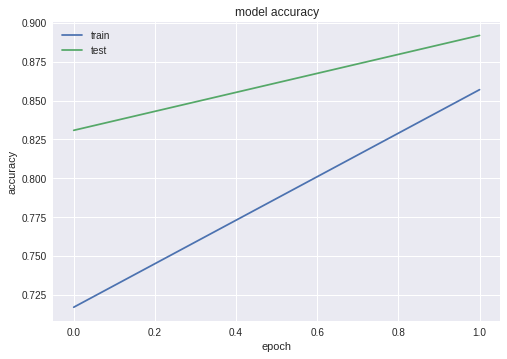

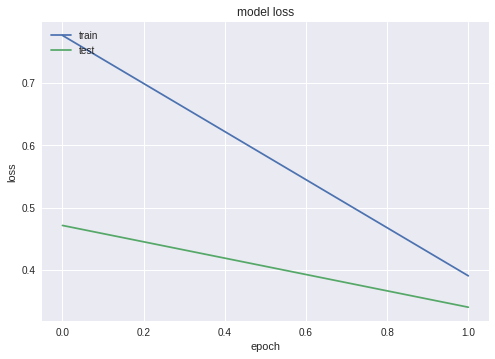

In [11]:
model = train_model2(X_train, y_train)

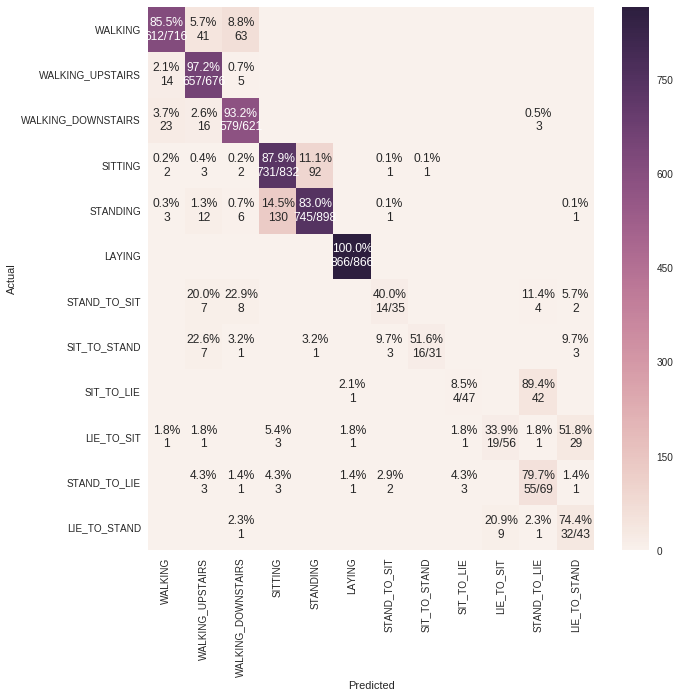

[[612  41  63   0   0   0   0   0   0   0   0   0]
 [ 14 657   5   0   0   0   0   0   0   0   0   0]
 [ 23  16 579   0   0   0   0   0   0   0   3   0]
 [  2   3   2 731  92   0   1   1   0   0   0   0]
 [  3  12   6 130 745   0   1   0   0   0   0   1]
 [  0   0   0   0   0 866   0   0   0   0   0   0]
 [  0   7   8   0   0   0  14   0   0   0   4   2]
 [  0   7   1   0   1   0   3  16   0   0   0   3]
 [  0   0   0   0   0   1   0   0   4   0  42   0]
 [  1   1   0   3   0   1   0   0   1  19   1  29]
 [  0   3   1   3   0   1   2   0   3   0  55   1]
 [  0   0   1   0   0   0   0   0   0   9   1  32]]
[88.548057259713701, 88.548057259713701, 88.548057259713701, 88.548057259713701, 88.548057259713701, 88.548057259713701, 88.548057259713701, 88.548057259713701, 88.548057259713701, 88.548057259713701]
Accuracy: 88.548% (+/-0.000)


In [12]:
test_model2(X_test, y_test, model, ACTIVITIES)
get_model_accuracy2(X_test, y_test, model)

In [13]:
frozen_graph = freeze_session(K.get_session(),
                              output_names=[out.op.name for out in model.outputs])

tf.train.write_graph(frozen_graph, "models", "har_hapt.pb", as_text=False)


INFO:tensorflow:Froze 35 variables.
Converted 35 variables to const ops.


'models/har_hapt.pb'

In [14]:
model.save('models/har_hapt2.h5')